# 1. Introduction

In this lab, you will work with autoencoders and GANs.

# 2. Denoising Autoencoder

Create a denoising autoencoder and a denoising variational autoencoder to remove noise using kaggle denoising competition. The denoising autoencoder competition can be found at https://www.kaggle.com/c/denoising-dirty-documents.

If you want to look at Variational Autoencoders to solve the problem, a good source can be found in:

https://keras.io/examples/generative/vae/

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(258, 540, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(33 * 68 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((33, 68, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Cropping2D(cropping=((3, 3), (2, 2)))(x)  # To get exact 258x540 shape
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 258, 540, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 129, 270, 32)   │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 65, 135, 64)    │         18,496 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 33, 68, 128)    │         73,856 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 287232)         │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │     73,531,648 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         16,448 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         16,448 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 73,657,216 (280.98 MB)

 Trainable params: 73,657,216 (280.98 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 287232)              │      18,670,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 33, 68, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 66, 136, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 132, 272, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 264, 544, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 258, 540, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 258, 540, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,910,209 (72.14 MB)

 Trainable params: 18,910,209 (72.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        noise_image, clean_image = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(noise_image)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(clean_image, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        noise_image, clean_image = data

        z_mean, z_log_var, z = self.encoder(noise_image)
        reconstruction = self.decoder(z)
        reconstruction_loss = ops.mean(
        ops.sum(
                keras.losses.binary_crossentropy(clean_image, reconstruction),
                axis=(1, 2),
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
os.mkdir("train_images")
os.mkdir("train_cleaned_images")
os.mkdir("test_images")

In [ ]:
from zipfile import ZipFile

with ZipFile("train_images/train.zip", "r") as zipobj:
    zipobj.extractall("train_images")

with ZipFile("train_cleaned_images/train_cleaned.zip", "r") as zipobj:
    zipobj.extractall("train_cleaned_images")

with ZipFile("test_images/test.zip", "r") as zipobj:
    zipobj.extractall("test_images")

In [ ]:
train_images = [os.path.join('train_images/train', image) for image in os.listdir('train_images/train')]
test_images = [os.path.join('test_images/test', image) for image in os.listdir('test_images/test')]
cleaned_images = [os.path.join('train_cleaned_images/train_cleaned', image) for image in os.listdir('train_cleaned_images/train_cleaned')]

In [ ]:
os.mkdir("train_images/train_resized")
os.mkdir("train_cleaned_images/train_cleaned_resized")
os.mkdir("test_images/test_resized")

In [ ]:
import matplotlib.pyplot as plt

def split_and_save_images(images, output_folder):
    for image in images:
        img = plt.imread(image)
        if img.shape == (420, 540):
            # Split the image into two images of size 258x540
            img1 = img[0:258, :]
            img2 = img[(420-258):, :]

            filename = os.path.basename(image).split('.')[0]
            filename1 = filename + '_1.png'
            filename2 = filename + '_2.png'

            # Save the two images into the output folder
            plt.imsave(os.path.join(output_folder, filename1), img1, cmap='gray')
            plt.imsave(os.path.join(output_folder, filename2), img2, cmap='gray')
        else:
            # Save the small image into the output folder without cropping
            filename = os.path.basename(image)
            plt.imsave(os.path.join(output_folder, filename), img, cmap='gray')

split_and_save_images(train_images, 'train_images/train_resized')
split_and_save_images(cleaned_images, 'train_cleaned_images/train_cleaned_resized')
split_and_save_images(test_images, 'test_images/test_resized')

In [ ]:
train_images_resized = [os.path.join('train_images/train_resized', image) for image in os.listdir('train_images/train_resized')]
test_images_resized = [os.path.join('test_images/test_resized', image) for image in os.listdir('test_images/test_resized')]
cleaned_images_resized = [os.path.join('train_cleaned_images/train_cleaned_resized', image) for image in os.listdir('train_cleaned_images/train_cleaned_resized')]

(240, 258, 540, 1)
(120, 258, 540, 1)
(240, 258, 540, 1)


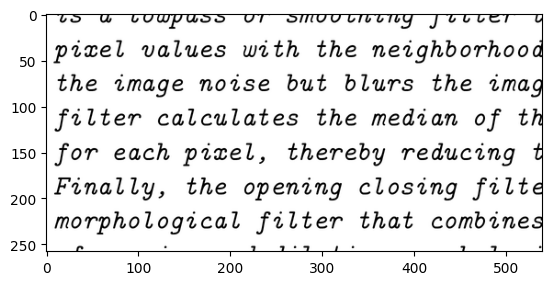

In [ ]:
def process_images(image_paths):
    image_array = np.empty((len(image_paths), 258, 540, 1), dtype=np.float32)

    for i, image_path in enumerate(image_paths):
        img = plt.imread(image_path)

        if img.shape[-1] == 4:  # Check if the image has an alpha channel
            img = img[..., :3]  # Discard the alpha channel by selecting only the first three channels

        if len(img.shape) == 2:  # Check if the image is already grayscale
            gray_img = img[..., np.newaxis]  # Add a new axis to make it (height, width, 1)
        else:
            gray_img = np.mean(img, axis=2, keepdims=True)  # Convert the image to grayscale

        plt.imshow(gray_img[:, :, 0], cmap='gray')
#         print(gray_img.shape)

        # Store the image in the array
        image_array[i] = gray_img
    return image_array

# Process train_images
train_array = process_images(train_images_resized)
print(train_array.shape)

# Process test_images
test_array = process_images(test_images_resized)
print(test_array.shape)

# Process cleaned_images
clean_array = process_images(cleaned_images_resized)
print(clean_array.shape)

In [ ]:
X_train = train_array
X_test = test_array
y_train = clean_array

X_train.shape, X_test.shape, y_train.shape

((240, 258, 540, 1), (120, 258, 540, 1), (240, 258, 540, 1))

In [ ]:
def create_train_val_split(X, y, val_split=0.2):
    n = len(X)
    indices = np.arange(n)
    np.random.shuffle(indices)
    val_size = int(n * val_split)
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    return X_train, y_train, X_val, y_val

In [ ]:
lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

def ensure_normalized(data):
    if data.max() > 1.0:
        return data / 255.0
    return data

In [ ]:
class PairedDataGenerator(keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size=16, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
def train_vae(X_train, y_train, X_test=None, y_test=None, epochs=100, batch_size=8):
    # Ensure data is normalized
    X_train = ensure_normalized(X_train)
    y_train = ensure_normalized(y_train)
    if X_test is not None:
        X_test = ensure_normalized(X_test)
    if y_test is not None:
        y_test = ensure_normalized(y_test)

    # Create and compile the model with a smaller learning rate
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

    # Split data if validation data not provided
    if X_test is None or y_test is None:
        print("Creating validation split from training data...")
        X_train_split, y_train_split, X_val_split, y_val_split = create_train_val_split(X_train, y_train, val_split=0.2)
    else:
        print("Using provided validation data...")
        X_train_split, y_train_split = X_train, y_train
        X_val_split, y_val_split = X_test, y_test

    # Create data generators
    train_gen = PairedDataGenerator(X_train_split, y_train_split, batch_size=batch_size)
    val_gen = PairedDataGenerator(X_val_split, y_val_split, batch_size=batch_size, shuffle=False)

    # Callbacks
    callbacks = [
        lr_reducer,
        early_stopping,
        keras.callbacks.TerminateOnNaN()  # Stop training if NaN detected
    ]

    # Train with smaller batch size and lower learning rate
    history = vae.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    return vae, history

In [ ]:
X_train_split, y_train_split, X_val_split, y_val_split = create_train_val_split(X_train, y_train, val_split=0.2)

vae, history = train_vae(
    X_train_split,
    y_train_split,
    X_test=X_val_split,
    y_test=y_val_split,
    epochs=100,
    batch_size=8  # Smaller batch size for stability
)

Using provided validation data...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - kl_loss: 1418.7227 - loss: 89689.4766 - reconstruction_loss: 88270.7500 - val_kl_loss: 2779.5476 - val_loss: 58793.2461 - val_reconstruction_loss: 56013.6992 - learning_rate: 1.0000e-04
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - kl_loss: 1655.2120 - loss: 53455.8594 - reconstruction_loss: 51800.6523 - val_kl_loss: 231.1044 - val_loss: 48800.4844 - val_reconstruction_loss: 48569.3867 - learning_rate: 1.0000e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - kl_loss: 207.5204 - loss: 48141.3633 - reconstruction_loss: 47933.8477 - val_kl_loss: 160.1046 - val_loss: 47763.5156 - val_reconstruction_loss: 47603.4062 - learning_rate: 1.0000e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - kl_loss: 160.3267 - loss: 47592.2422 - reconstruction_loss: 47431.9141 - val_kl_loss: 160.4265 - val_loss: 47648.8242 - val_reconstruction_loss: 47488.3945 - learning_rate: 1.0000e-04
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


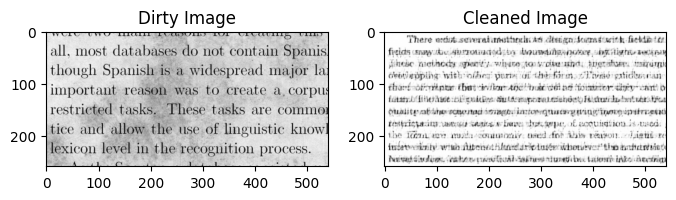

In [ ]:
def clean_image(vae, dirty_image):
    """Cleans a dirty image using the trained VAE."""
    # Assuming dirty_image is a single image with shape (258, 540, 1)
    dirty_image = dirty_image / 255.0  # Normalize
    dirty_image = np.expand_dims(dirty_image, axis=0)  # Add batch dimension

    z_mean, z_log_var, z = vae.encoder.predict(dirty_image)
    cleaned_image = vae.decoder.predict(z)

    cleaned_image = np.squeeze(cleaned_image, axis=0) # remove batch dimension
    cleaned_image = cleaned_image * 255.0 #denormalize
    cleaned_image = np.clip(cleaned_image, 0, 255).astype(np.uint8) #ensure values are within valid range
    return cleaned_image

# Example: Clean a single image from X_test
dirty_image_to_clean = X_test[5]  # Get a dirty image
cleaned_image = clean_image(vae, dirty_image_to_clean)

# Display the original and cleaned images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(dirty_image_to_clean[:, :, 0], cmap='gray')
plt.title("Dirty Image")
plt.subplot(1, 2, 2)
plt.imshow(cleaned_image[:, :, 0], cmap='gray')
plt.title("Cleaned Image")
plt.show()

# 3. DCGAN

Look at https://keras.io/examples/generative/dcgan_overriding_train_step/.

We will use a DCGAN to generate new pokemons or african fabric images.

Datasets can be found in:

- https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types
- https://www.kaggle.com/mikuns/african-fabric



In [ ]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [ ]:
try:
  os.makedirs("pokemon_gan")
except:
  pass

with ZipFile("pokemon_gan/images.zip", "r") as zipobj:
    zipobj.extractall("pokemon_gan")

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "pokemon_gan", label_mode=None, image_size=(120, 120), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 809 files.


(120, 120, 3)


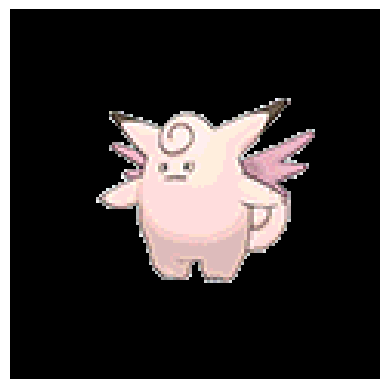

In [ ]:
for x in dataset:
    print(x[0].shape)
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(120, 120, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 60, 60, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          28,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,409 (1.62 MB)

 Trainable params: 425,409 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(15 * 15 * 128),
        layers.Reshape((15, 15, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 28800)               │       3,715,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 30, 30, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 60, 60, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 60, 60, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 120, 120, 512)       │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 120, 120, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 120, 120, 3)         │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,638,083 (25.32 MB)

 Trainable params: 6,638,083 (25.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("pokemon_images/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 998ms/step - d_loss: 0.6500 - g_loss: 1.0570
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 772ms/step - d_loss: 0.3785 - g_loss: 1.5253
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 759ms/step - d_loss: 0.7319 - g_loss: 1.1649
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 771ms/step - d_loss: 0.6067 - g_loss: 1.2939
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 781ms/step - d_loss: 0.5338 - g_loss: 1.4216
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - d_loss: 0.5313 - g_loss: 1.3214
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 772ms/step - d_loss: 0.3909 - g_loss: 1.9623
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 771ms/step - d_loss: 0.4541 - g_loss: 1.7314
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 773ms/step - d_loss: 0.7922 - g_loss: 0.8519
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - d_loss: 0.5423 - g_loss: 1.2348
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - d_loss: 0.5833 - g_loss: 1.2639
Epoch 12/100
26/26 ━━━━━━━━━━━

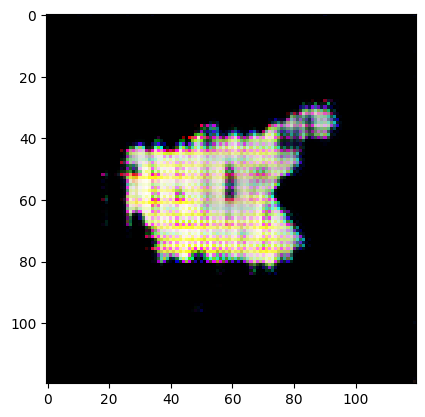

In [ ]:
img = keras.utils.load_img("pokemon_images/generated_img_099_4.png")

plt.imshow(keras.utils.img_to_array(img).astype("int32"))

# 4. Diffusion Methods

Look at:

- https://keras.io/examples/generative/ddim/
- https://drive.google.com/file/d/1DYHDbt1tSl9oqm3O333biRYzSCOtdtmn/view

Explain how diffusion models work: by explaining the forward process, the backward process, the training process and the loss equation

Diffusion models work by doing 2 steps, forward diffusion, which progressively add noise to sample images using a fixed process, and backwards diffusion, which trains a model to work backwards to get back the original image from the noisy one.

**Forward Diffusion process:**  The first process of training a diffusion model, in which data samples are images are gradually made noiser over a period of t time steps. Typically, noise is added to an image by sampling from a normal distribution and adding that to the image at each time step. The final image should be completely noisy.

**Backward Diffusion process:** The second process of training a diffusion model, which involves teaching the model to reverse the forward diffusion process, working its way back through the noisy images to reach the original image. By doing this, we can have the model generate original images simply by starting with an image of pure noise and seeing what the model interprets the noise to be.

**Training process:** The process through the diffusion model is trained is by doing the forward and backward diffusion proccesses over and over again. During the backward process, the model tries to predict the noise component of each image, seperating each image into its previous image + its noise component.

**Loss equation:** The loss equation of diffusion model is similar to that of variational auto encoders, in that the loss equation is based off the variational upper bound of the negative log likelihood. This loss function tries to lower this upper bound as much as possible, which in terms of how the model works, means that the model tries to make its prediction of the noise added as close as possible to the actual noise that was added.